In [1]:
import numpy as np
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tqdm.notebook import tqdm
from copy import deepcopy
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sacred import Experiment
import rock_paper_scissors as rps
from rps_rl import RPCEnv, RPCAgent, Monitor, Universe

## All outcomes (sanity check)

In [2]:
rps.print_outcomes()

R vs R => tie
R vs P => R loses
R vs S => R wins
P vs R => P wins
P vs P => tie
P vs S => P loses
S vs R => S loses
S vs P => S wins
S vs S => tie


## Initial training phase

In [3]:
# environment
env = RPCEnv(noise_dim=4)

# how many agents to create?
N_AGENTS = 10

# how many games to play during test?
N_GAMES = 1000

# creating agents
AGENTS = [RPCAgent(noise_dim=env.noise_dim, identity=i) for i in range(N_AGENTS)]

# to track the performance
m = Monitor(agents=AGENTS)

In [4]:
def sample_agent():
    """Get one of the agents."""
    return np.random.choice(AGENTS)

In [5]:
# Running training games
for _ in tqdm(range(N_GAMES)):
    A1, A2 = sample_agent(), sample_agent()
    A1.do_train = True
    A2.do_train = True
    U = Universe(environment=env, agents=[A1, A2], monitor=m)
    rew = U.episode()
    del U

In [6]:
AGENTS

[<Agent id=0 wisdom=218 opponents=10>,
 <Agent id=1 wisdom=171 opponents=10>,
 <Agent id=2 wisdom=198 opponents=10>,
 <Agent id=3 wisdom=188 opponents=10>,
 <Agent id=4 wisdom=213 opponents=10>,
 <Agent id=5 wisdom=197 opponents=10>,
 <Agent id=6 wisdom=215 opponents=10>,
 <Agent id=7 wisdom=202 opponents=10>,
 <Agent id=8 wisdom=198 opponents=10>,
 <Agent id=9 wisdom=200 opponents=10>]

## Train stats

In [7]:
m.stats()

{'reward': {<Agent id=0 wisdom=218 opponents=10>: {-1: 75, 0: 69, 1: 74},
  <Agent id=1 wisdom=171 opponents=10>: {-1: 65, 0: 42, 1: 64},
  <Agent id=2 wisdom=198 opponents=10>: {-1: 69, 0: 60, 1: 69},
  <Agent id=3 wisdom=188 opponents=10>: {-1: 53, 0: 61, 1: 74},
  <Agent id=4 wisdom=213 opponents=10>: {-1: 65, 0: 75, 1: 73},
  <Agent id=5 wisdom=197 opponents=10>: {-1: 74, 0: 57, 1: 66},
  <Agent id=6 wisdom=215 opponents=10>: {-1: 78, 0: 69, 1: 68},
  <Agent id=7 wisdom=202 opponents=10>: {-1: 60, 0: 79, 1: 63},
  <Agent id=8 wisdom=198 opponents=10>: {-1: 72, 0: 53, 1: 73},
  <Agent id=9 wisdom=200 opponents=10>: {-1: 71, 0: 71, 1: 58}},
 'action': {<Agent id=0 wisdom=218 opponents=10>: [82, 72, 64],
  <Agent id=1 wisdom=171 opponents=10>: [72, 52, 47],
  <Agent id=2 wisdom=198 opponents=10>: [73, 43, 82],
  <Agent id=3 wisdom=188 opponents=10>: [56, 49, 83],
  <Agent id=4 wisdom=213 opponents=10>: [58, 83, 72],
  <Agent id=5 wisdom=197 opponents=10>: [80, 66, 51],
  <Agent id=6 w

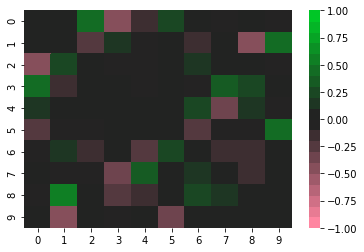

In [8]:
matrix = np.zeros((len(AGENTS), len(AGENTS)))
for i1, A1 in enumerate(AGENTS):
    for i2, A2 in enumerate(AGENTS):
        matrix[i1, i2] = np.mean(A1.reward_by_opponent[A2])
cm = sns.diverging_palette(0, 129, l=70, s=100, n=20, center="dark")
sns.heatmap(matrix, vmin=-1, vmax=1, cmap=cm)

## Running without training

In [9]:
# our agent
A = AGENTS[0]

# number of games to test for each agent
N_TEST_GAMES = 10

# to track the performance
m_test = Monitor(agents=AGENTS)

# Running training games
for _ in tqdm(range(N_TEST_GAMES)):
    for A2 in AGENTS[1:]:
        A.do_train = False
        A2.do_train = False
        U = Universe(environment=env, agents=[A, A2], monitor=m_test)
        rew = U.episode()
        del U

In [10]:
results = {x: y[AGENTS[0]] for x, y in m_test.stats().items()}

In [11]:
results['action']

[39, 28, 23]

In [12]:
rew = results['reward']

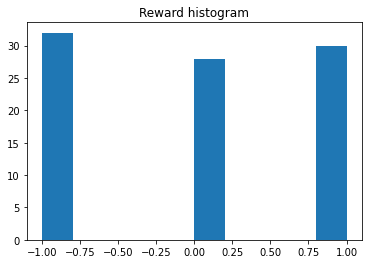

In [13]:
plt.title("Reward histogram")
plt.hist([x for x, y in rew.items() for _ in range(y)])
plt.show()

# Playing with an UNKNOWN opponent

In [14]:
A1 = AGENTS[0]
A2 = np.random.choice(AGENTS[1:])
true_opponent = AGENTS.index(A2)
true_opponent

9

In [15]:
A1.do_train = False
A2.do_train = False

## Identifying threat

In [16]:
# to track the performance
m_estimate = Monitor(agents=AGENTS)

U = Universe(environment=env, agents=[A1, A2], monitor=m_estimate)
for _ in tqdm(range(50)):
    rew = U.episode()

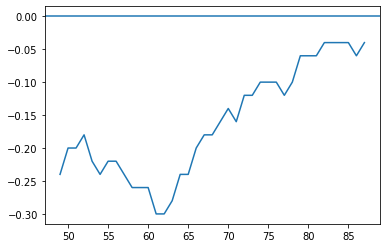

In [17]:
plt.plot(pd.Series(A1.reward_by_opponent[A2]).rolling(50).mean())
plt.axhline(0)

In [18]:
def dict_argmax(d):
    keys = list(d.keys())
    vals = [d[k] for k in keys]
    idx = np.argmax(vals)
    return keys[idx]

agent_logprobs = {A: 0 for A in AGENTS}
for (_, _, (xi, a1, a2, (r1, r2))) in m_estimate.data:
    for A in AGENTS:
        agent_logprobs[A] += np.log(A.model(np.array([xi]))[0][a2].numpy())
estimated_agent = dict_argmax(agent_logprobs)

In [19]:
print("Estimated id %d True id %d" % (estimated_agent.identity, A2.identity))

Estimated id 9 True id 9


### Adversarial training

In [20]:
A1.do_train = True
estimated_agent.do_train = False

In [21]:
U = Universe(environment=env, agents=[A1, estimated_agent], monitor=m_estimate)
for _ in tqdm(range(1000)):
    rew = U.episode()

### Testing time! 

In [22]:
# to track the performance
m_estimate = Monitor(agents=AGENTS)

U = Universe(environment=env, agents=[A1, A2], monitor=m_estimate)
for _ in tqdm(range(50)):
    rew = U.episode()

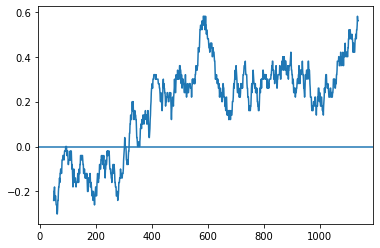

In [23]:
plt.plot(pd.Series(A1.reward_by_opponent[A2]).rolling(50).mean())
plt.axhline(0)